## 1. IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

## 2. CHARGEMENT DES DONNÉES

In [2]:
# Charger le dataset
df = pd.read_csv('dataset_bankruptcy_prediction.csv')
df

,affiliateNumber,firm_age_years,firm_size_log,debt_risk_score,stability_index,regional_risk,bank_accountDefaultState
0,1905845,64.666667,7.013016,0.6,1.000000,0.088261,0.0
1,1928079,64.666667,5.730100,0.6,1.000000,0.078044,0.0
2,1929415,64.666667,2.890372,0.6,1.000000,0.088658,0.0
3,1839466,59.916667,3.663562,0.6,1.000000,0.088658,1.0
4,2062404,35.500000,2.302585,0.6,1.000000,0.088261,0.0
...,...,...,...,...,...,...,...
161249,4172638,2.083333,0.693147,0.6,0.139863,0.061070,0.0
161250,5140404,2.083333,1.098612,0.6,0.234920,0.078044,0.0
161251,5124068,2.083333,0.693147,0.6,0.120269,0.069831,0.0
161252,5131859,2.083333,0.693147,0.6,0.142555,0.071741,0.0


In [3]:
# Info du dataset
print(" Informations du dataset :\n")
print(df.info())

print("\n Statistiques descriptives :\n")
print(df.describe())

 Informations du dataset :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161254 entries, 0 to 161253
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   affiliateNumber           161254 non-null  int64  
 1   firm_age_years            161254 non-null  float64
 2   firm_size_log             161254 non-null  float64
 3   debt_risk_score           161254 non-null  float64
 4   stability_index           161254 non-null  float64
 5   regional_risk             161254 non-null  float64
 6   bank_accountDefaultState  161254 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 8.6 MB
None

 Statistiques descriptives :

       affiliateNumber  firm_age_years  firm_size_log  debt_risk_score  \
count     1.612540e+05   161254.000000  161254.000000    161254.000000   
mean      4.706731e+06       11.870574       1.295618         0.618837   
std       2.543885e+06        9.792639       0.903

 Distribution de la cible : bank_accountDefaultState

  SAINE      :    149,466 (92.69%)
  FAILLITE   :     11,788 ( 7.31%)


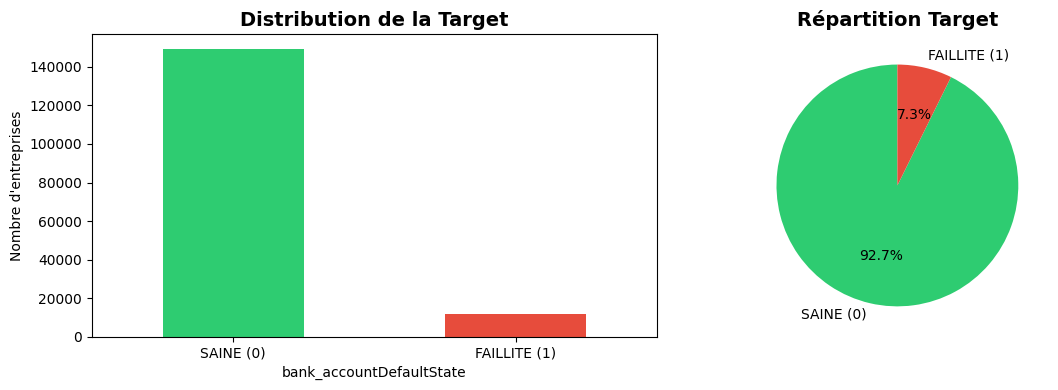

In [4]:
# Distribution de la target
print(" Distribution de la cible : bank_accountDefaultState\n")
target_dist = df['bank_accountDefaultState'].value_counts()
for val, count in target_dist.items():
    pct = count / len(df) * 100
    label = "SAINE" if val == 0 else "FAILLITE"
    print(f"  {label:10s} : {count:10,} ({pct:5.2f}%)")

# Visualisation
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Barplot
target_dist.plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Distribution de la Target', fontsize=14, fontweight='bold')
ax[0].set_xlabel('bank_accountDefaultState')
ax[0].set_ylabel('Nombre d\'entreprises')
ax[0].set_xticklabels(['SAINE (0)', 'FAILLITE (1)'], rotation=0)

# Pie chart
ax[1].pie(target_dist.values, labels=['SAINE (0)', 'FAILLITE (1)'], 
          autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
ax[1].set_title('Répartition Target', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. PRÉPARATION DES DONNÉES

In [5]:
# Séparer features et target
X = df.drop(['bank_accountDefaultState', 'affiliateNumber'], axis=1).copy()
y = df['bank_accountDefaultState'].copy()

print(f"Features (X) : {X.shape}")
print(f"Target (y) : {y.shape}")
print(f"\nFeatures utilisées :")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

Features (X) : (161254, 5)
Target (y) : (161254,)

Features utilisées :
  1. firm_age_years
  2. firm_size_log
  3. debt_risk_score
  4. stability_index
  5. regional_risk


In [6]:
# Split train/test (80/20) avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Split des données (80% train / 20% test)\n")
print(f"  Train : {X_train.shape[0]:8,} lignes")
print(f"  Test  : {X_test.shape[0]:8,} lignes")

Split des données (80% train / 20% test)

  Train :  129,003 lignes
  Test  :   32,251 lignes


## 4. NORMALISATION

In [7]:
train_mean = X_train.mean()
train_std = X_train.std()

# Éviter division par zéro
train_std = train_std.replace(0, 1)

# Normaliser train et test
X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std

print(f"\nStats après normalisation (Train) :")
print(f"  Moyenne : {X_train_scaled.mean().mean():.6f}")
print(f"  Std     : {X_train_scaled.std().mean():.6f}")

# Convertir en numpy
X_train_np = X_train_scaled.values
X_test_np = X_test_scaled.values
y_train_np = y_train.values.astype(int)
y_test_np = y_test.values.astype(int)


Stats après normalisation (Train) :
  Moyenne : 0.000000
  Std     : 1.000000


## 5. OPTIMISATION DE K avec Cross-Validation

  k= 3 : F1-Score = 0.7759
  k= 5 : F1-Score = 0.7882
  k= 7 : F1-Score = 0.7903
  k= 9 : F1-Score = 0.7910
  k=11 : F1-Score = 0.7910
  k=15 : F1-Score = 0.7910

Meilleur k = 9 (F1-Score = 0.7910)


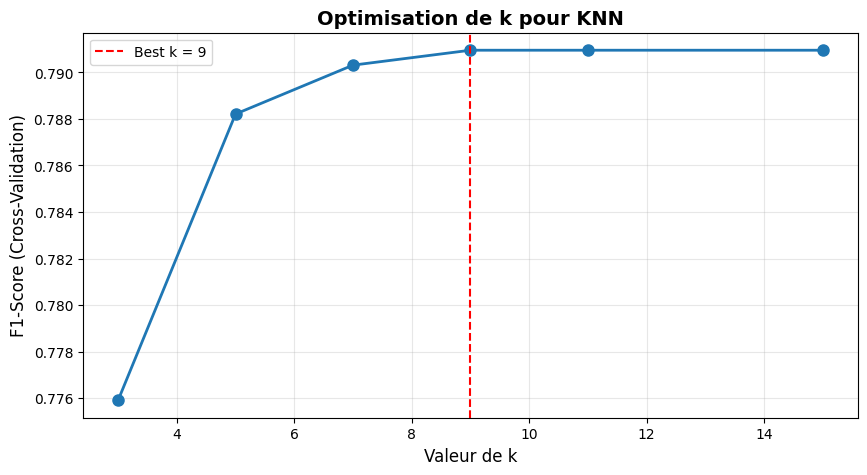

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# Échantillonner
sample_size = min(50000, len(X_train_np))
sample_idx = np.random.choice(len(X_train_np), sample_size, replace=False)
X_sample = X_train_np[sample_idx]
y_sample = y_train_np[sample_idx]

# Tester différentes valeurs de k
k_values = [3, 5, 7, 9, 11, 15]
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_sample, y_sample, cv=3, scoring='f1')
    mean_score = scores.mean()
    cv_scores.append(mean_score)
    print(f"  k={k:2d} : F1-Score = {mean_score:.4f}")

# Meilleur k
best_k = k_values[np.argmax(cv_scores)]
best_score = max(cv_scores)

print(f"\nMeilleur k = {best_k} (F1-Score = {best_score:.4f})")

# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(k_values, cv_scores, marker='o', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel('Valeur de k', fontsize=12)
plt.ylabel('F1-Score (Cross-Validation)', fontsize=12)
plt.title('Optimisation de k pour KNN', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 6. KNN FROM SCRATCH

In [9]:
class KNNFromScratch:
    """
    K-Nearest Neighbors FROM SCRATCH
    Classification binaire avec distance euclidienne
    """
    
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def train(self, X, y):
        """Stocker les données d'entraînement"""
        self.X_train = X
        self.y_train = y
        return self
    
    def _euclidean_distance(self, x1, x2):
        """Calculer la distance euclidienne"""
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _predict_single(self, x):
        """Prédire pour un seul échantillon"""
        # Calculer distances
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        
        # k plus proches voisins
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        
        # Vote majoritaire
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]
    
    def predict(self, X):
        """Prédire pour plusieurs échantillons"""
        return np.array([self._predict_single(x) for x in X])

print("Classe KNNFromScratch créée")

Classe KNNFromScratch créée


In [10]:
# Entraîner KNN from scratch
train_sample_size = min(20000, len(X_train_np))
train_idx = np.random.choice(len(X_train_np), train_sample_size, replace=False)

knn_scratch = KNNFromScratch(k=best_k)
knn_scratch.train(X_train_np[train_idx], y_train_np[train_idx])

print(f"KNN entraîné sur {train_sample_size:,} échantillons")
print(f"Paramètre k = {best_k}")

KNN entraîné sur 20,000 échantillons
Paramètre k = 9


In [11]:
# Prédiction sur TEST (échantillon)
print("Prédiction sur TEST (1000 échantillons)...\n")

test_sample_size = 1000
test_idx = np.random.choice(len(X_test_np), test_sample_size, replace=False)
X_test_sample = X_test_np[test_idx]
y_test_sample = y_test_np[test_idx]

y_pred_knn = knn_scratch.predict(X_test_sample)

print("Prédictions KNN terminées")

Prédiction sur TEST (1000 échantillons)...

Prédictions KNN terminées


## 7. ÉVALUATION KNN

In [12]:
# Métriques KNN
print("ÉVALUATION KNN FROM SCRATCH\n")
print("="*60)

acc_knn = accuracy_score(y_test_sample, y_pred_knn)
prec_knn = precision_score(y_test_sample, y_pred_knn, zero_division=0)
recall_knn = recall_score(y_test_sample, y_pred_knn, zero_division=0)
f1_knn = f1_score(y_test_sample, y_pred_knn, zero_division=0)

print(f"  Accuracy  : {acc_knn:.4f}")
print(f"  Precision : {prec_knn:.4f}")
print(f"  Recall    : {recall_knn:.4f}")
print(f"  F1-Score  : {f1_knn:.4f}")
print("\n" + "="*60)

# Rapport détaillé
print("\nRapport de classification détaillé :\n")
print(classification_report(y_test_sample, y_pred_knn, 
                          target_names=['SAINE (0)', 'FAILLITE (1)']))

ÉVALUATION KNN FROM SCRATCH

  Accuracy  : 0.9780
  Precision : 1.0000
  Recall    : 0.7284
  F1-Score  : 0.8429


Rapport de classification détaillé :

              precision    recall  f1-score   support

   SAINE (0)       0.98      1.00      0.99       919
FAILLITE (1)       1.00      0.73      0.84        81

    accuracy                           0.98      1000
   macro avg       0.99      0.86      0.92      1000
weighted avg       0.98      0.98      0.98      1000



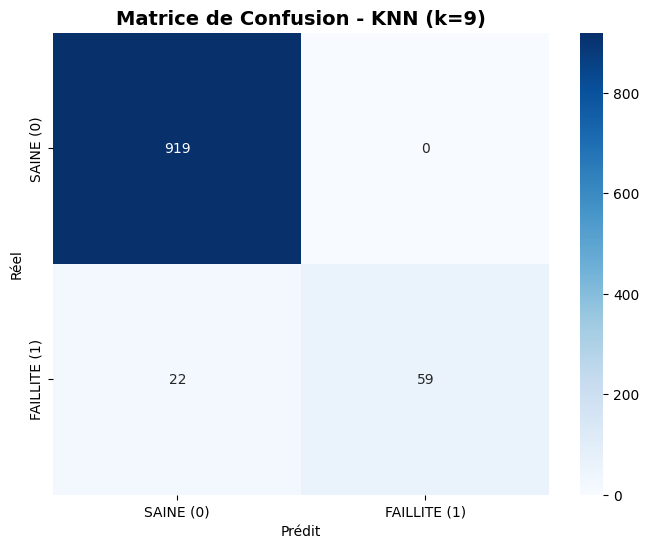


Interprétation Matrice de Confusion :
  Vrais Négatifs (TN)  : 919
  Faux Positifs (FP)   : 0
  Faux Négatifs (FN)   : 22
  Vrais Positifs (TP)  : 59


In [13]:
# Matrice de confusion KNN
cm_knn = confusion_matrix(y_test_sample, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['SAINE (0)', 'FAILLITE (1)'],
            yticklabels=['SAINE (0)', 'FAILLITE (1)'])
plt.title(f'Matrice de Confusion - KNN (k={best_k})', fontsize=14, fontweight='bold')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

print("\nInterprétation Matrice de Confusion :")
print(f"  Vrais Négatifs (TN)  : {cm_knn[0,0]:,}")
print(f"  Faux Positifs (FP)   : {cm_knn[0,1]:,}")
print(f"  Faux Négatifs (FN)   : {cm_knn[1,0]:,}")
print(f"  Vrais Positifs (TP)  : {cm_knn[1,1]:,}")

## 8. SVM FROM SCRATCH

In [14]:
class SVMFromScratch:
    """
    Support Vector Machine FROM SCRATCH
    Classification binaire avec gradient descent
    """
    
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
    
    def train(self, X, y):
        """Entraîner le SVM avec gradient descent"""
        n_samples, n_features = X.shape
        
        # Convertir labels {0,1} en {-1,1}
        y_ = np.where(y <= 0, -1, 1)
        
        # Initialiser poids et biais
        self.w = np.zeros(n_features)
        self.b = 0
        
        # Gradient descent
        for iteration in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]
            
            # Afficher progression
            if (iteration + 1) % 200 == 0:
                print(f"  Iteration {iteration + 1}/{self.n_iters}")
        
        return self
    
    def predict(self, X):
        """Prédire pour plusieurs échantillons"""
        linear_output = np.dot(X, self.w) - self.b
        # Convertir de {-1,1} vers {0,1}
        return np.where(linear_output >= 0, 1, 0)

print("Classe SVMFromScratch créée")

Classe SVMFromScratch créée


In [15]:
# Entraîner SVM from scratch
svm_sample_size = min(10000, len(X_train_np))
svm_idx = np.random.choice(len(X_train_np), svm_sample_size, replace=False)

svm_scratch = SVMFromScratch(learning_rate=0.001, lambda_param=0.01, n_iters=1000)
svm_scratch.train(X_train_np[svm_idx], y_train_np[svm_idx])

print(f"\nSVM entraîné sur {svm_sample_size:,} échantillons")

  Iteration 200/1000
  Iteration 400/1000
  Iteration 600/1000
  Iteration 800/1000
  Iteration 1000/1000

SVM entraîné sur 10,000 échantillons


In [16]:
# Prédiction SVM sur TEST
print("Prédiction SVM sur TEST...\n")

y_pred_svm = svm_scratch.predict(X_test_sample)

print("Prédictions SVM terminées")

Prédiction SVM sur TEST...

Prédictions SVM terminées


## 9. ÉVALUATION SVM

In [17]:
# Métriques SVM
print("ÉVALUATION SVM FROM SCRATCH\n")
print("="*60)

acc_svm = accuracy_score(y_test_sample, y_pred_svm)
prec_svm = precision_score(y_test_sample, y_pred_svm, zero_division=0)
recall_svm = recall_score(y_test_sample, y_pred_svm, zero_division=0)
f1_svm = f1_score(y_test_sample, y_pred_svm, zero_division=0)

print(f"  Accuracy  : {acc_svm:.4f}")
print(f"  Precision : {prec_svm:.4f}")
print(f"  Recall    : {recall_svm:.4f}")
print(f"  F1-Score  : {f1_svm:.4f}")
print("\n" + "="*60)

# Rapport détaillé
print("\nRapport de classification détaillé :\n")
print(classification_report(y_test_sample, y_pred_svm, 
                          target_names=['SAINE (0)', 'FAILLITE (1)']))

ÉVALUATION SVM FROM SCRATCH

  Accuracy  : 0.9780
  Precision : 1.0000
  Recall    : 0.7284
  F1-Score  : 0.8429


Rapport de classification détaillé :

              precision    recall  f1-score   support

   SAINE (0)       0.98      1.00      0.99       919
FAILLITE (1)       1.00      0.73      0.84        81

    accuracy                           0.98      1000
   macro avg       0.99      0.86      0.92      1000
weighted avg       0.98      0.98      0.98      1000



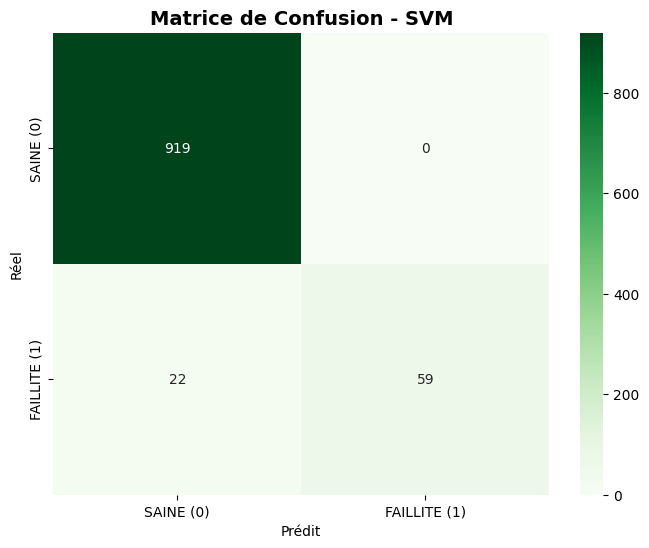


Interprétation Matrice de Confusion :
  Vrais Négatifs (TN)  : 919
  Faux Positifs (FP)   : 0
  Faux Négatifs (FN)   : 22
  Vrais Positifs (TP)  : 59


In [18]:
# Matrice de confusion SVM
cm_svm = confusion_matrix(y_test_sample, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['SAINE (0)', 'FAILLITE (1)'],
            yticklabels=['SAINE (0)', 'FAILLITE (1)'])
plt.title('Matrice de Confusion - SVM', fontsize=14, fontweight='bold')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

print("\nInterprétation Matrice de Confusion :")
print(f"  Vrais Négatifs (TN)  : {cm_svm[0,0]:,}")
print(f"  Faux Positifs (FP)   : {cm_svm[0,1]:,}")
print(f"  Faux Négatifs (FN)   : {cm_svm[1,0]:,}")
print(f"  Vrais Positifs (TP)  : {cm_svm[1,1]:,}")

## 10. COMPARAISON KNN vs SVM

In [19]:
# Tableau comparatif
comparison_df = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'KNN': [acc_knn, prec_knn, recall_knn, f1_knn],
    'SVM': [acc_svm, prec_svm, recall_svm, f1_svm]
})

comparison_df['Meilleur'] = comparison_df.apply(
    lambda row: '🔵 KNN' if row['KNN'] > row['SVM'] else ('🟢 SVM' if row['SVM'] > row['KNN'] else '🤝 Égalité'),
    axis=1
)

print("📊 COMPARAISON KNN vs SVM\n")
print(comparison_df.to_string(index=False))

📊 COMPARAISON KNN vs SVM

 Métrique      KNN      SVM  Meilleur
 Accuracy 0.978000 0.978000 🤝 Égalité
Precision 1.000000 1.000000 🤝 Égalité
   Recall 0.728395 0.728395 🤝 Égalité
 F1-Score 0.842857 0.842857 🤝 Égalité


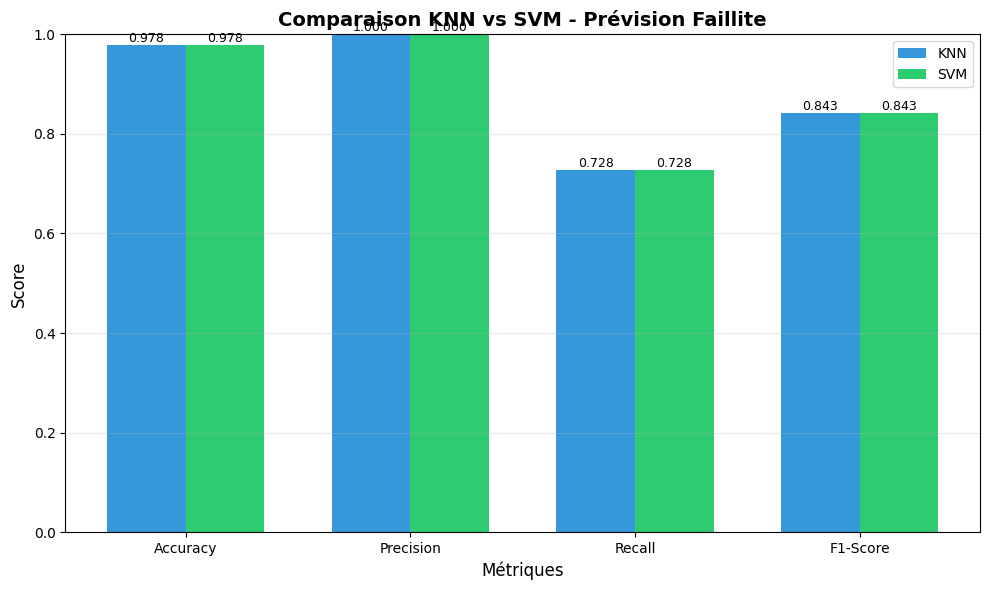

In [20]:
# Graphique comparatif
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
knn_scores = [acc_knn, prec_knn, recall_knn, f1_knn]
svm_scores = [acc_svm, prec_svm, recall_svm, f1_svm]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, knn_scores, width, label='KNN', color='#3498db')
bars2 = ax.bar(x + width/2, svm_scores, width, label='SVM', color='#2ecc71')

# Ajouter valeurs sur barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Métriques', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison KNN vs SVM - Prévision Faillite', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. SAUVEGARDE DES MODÈLES

In [21]:
# Sauvegarder les modèles et paramètres
artifacts = {
    'knn_scratch_bankruptcy.pkl': knn_scratch,
    'svm_scratch_bankruptcy.pkl': svm_scratch,
    'bankruptcy_features.pkl': list(X.columns),
    'bankruptcy_train_mean.pkl': train_mean,
    'bankruptcy_train_std.pkl': train_std,
    'best_k_bankruptcy.pkl': best_k,
}

print("Sauvegarde des artéfacts...\n")
for fname, obj in artifacts.items():
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)
    print(f"  ✓ {fname}")

print("\nTous les modèles FROM SCRATCH ont été sauvegardés !")

Sauvegarde des artéfacts...

  ✓ knn_scratch_bankruptcy.pkl
  ✓ svm_scratch_bankruptcy.pkl
  ✓ bankruptcy_features.pkl
  ✓ bankruptcy_train_mean.pkl
  ✓ bankruptcy_train_std.pkl
  ✓ best_k_bankruptcy.pkl

Tous les modèles FROM SCRATCH ont été sauvegardés !


## 12. RÉSUMÉ FINAL

In [22]:
print("="*80)
print("MINI-PROJET : PRÉVISION DE FAILLITE D'ENTREPRISE")
print("="*80)
print(f"\nRÉSUMÉ FINAL\n")
print(f"Dataset :")
print(f"  • Total entreprises : {df.shape[0]:,}")
print(f"  • Features          : 5 (simples et efficaces)")
print(f"  • Target            : bank_accountDefaultState")
print(f"  • Distribution      : {(y==0).sum():,} saines / {(y==1).sum():,} faillites")

print(f"\nModèles FROM SCRATCH :")
print(f"  • KNN : k = {best_k}")
print(f"  • SVM : Gradient Descent (1000 iterations)")

print(f"\nPerformances (sur échantillon test) :")
print(f"\n  KNN :")
print(f"    - Accuracy  : {acc_knn:.4f}")
print(f"    - Precision : {prec_knn:.4f}")
print(f"    - Recall    : {recall_knn:.4f}")
print(f"    - F1-Score  : {f1_knn:.4f}")

print(f"\n  SVM :")
print(f"    - Accuracy  : {acc_svm:.4f}")
print(f"    - Precision : {prec_svm:.4f}")
print(f"    - Recall    : {recall_svm:.4f}")
print(f"    - F1-Score  : {f1_svm:.4f}")

winner = "KNN" if f1_knn > f1_svm else "SVM"
print(f"\nMeilleur modèle (F1-Score) : {winner}")

print(f"\nFichiers sauvegardés :")
for fname in artifacts.keys():
    print(f"  • {fname}")

print(f"\n5 Features utilisées :")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

print("\n" + "="*80)
print("MINI-PROJET TERMINÉ AVEC SUCCÈS !")
print("="*80)
print("\nProchaine étape : Interface Streamlit pour prédictions en temps réel")

MINI-PROJET : PRÉVISION DE FAILLITE D'ENTREPRISE

RÉSUMÉ FINAL

Dataset :
  • Total entreprises : 161,254
  • Features          : 5 (simples et efficaces)
  • Target            : bank_accountDefaultState
  • Distribution      : 149,466 saines / 11,788 faillites

Modèles FROM SCRATCH :
  • KNN : k = 9
  • SVM : Gradient Descent (1000 iterations)

Performances (sur échantillon test) :

  KNN :
    - Accuracy  : 0.9780
    - Precision : 1.0000
    - Recall    : 0.7284
    - F1-Score  : 0.8429

  SVM :
    - Accuracy  : 0.9780
    - Precision : 1.0000
    - Recall    : 0.7284
    - F1-Score  : 0.8429

Meilleur modèle (F1-Score) : SVM

Fichiers sauvegardés :
  • knn_scratch_bankruptcy.pkl
  • svm_scratch_bankruptcy.pkl
  • bankruptcy_features.pkl
  • bankruptcy_train_mean.pkl
  • bankruptcy_train_std.pkl
  • best_k_bankruptcy.pkl

5 Features utilisées :
  1. firm_age_years
  2. firm_size_log
  3. debt_risk_score
  4. stability_index
  5. regional_risk

MINI-PROJET TERMINÉ AVEC SUCCÈS !

Pro